In [5]:
from itertools import chain, repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy.stats
import shap
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

from hp_pred.experiments import bootstrap_test, create_balanced_cv, objective_xgboost

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [6]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 60*5]

## Load and format data

In [7]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset_no_leading_time/cases/'))

static = pd.read_parquet('data/datasets/base_dataset_no_leading_time/meta.parquet')

data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)


train = data[data['split'] == "train"]
test = data[data['split'] == "test"]

train_case_label = train.groupby("caseid").agg(
                segment_count=("label", "count"),
                label_count=("label", "sum"),
            )



train_cv_split = create_balanced_cv(train_case_label, nb_max_iter=100000)

split 0 : 35,265 segments, 2,403 labels, 6.81% ratio label
split 1 : 34,690 segments, 2,788 labels, 8.04% ratio label
split 2 : 35,798 segments, 2,043 labels, 5.71% ratio label


## Train or load existing model


In [8]:
# control reproducibility
rng_seed = 42


FEATURE_NAME = (
    [
        f"{signal}_ema_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)


# create a regressor
train = train.dropna(subset=FEATURE_NAME)
test = test.dropna(subset=FEATURE_NAME)
print(
    f"{len(train):,d} train samples, "
    f"{len(test):,d} test samples, "
    f"{test['label'].mean():.2%} positive rate."
)

# Set model file, create models folder if does not exist.
model_folder = Path("data/models")
if not model_folder.exists():
    model_folder.mkdir()
model_file = model_folder / "xgb.json"


if model_file.exists():
    model = xgb.XGBClassifier()
    model.load_model(model_file)
else:
    # creat an optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_xgboost(trial, train, FEATURE_NAME, train_cv_split),
        n_trials=100,
        show_progress_bar=True,
    )

    # get the best hyperparameters
    best_params = study.best_params

    model = xgb.XGBClassifier(**best_params)
    # refit the model with best parameters
    model.fit(train[FEATURE_NAME], train.label, verbose=1)

    # save the model
    model.save_model(model_file)

105,753 train samples, 40,545 test samples, 7.08% positive rate.


## Evaluation

### Train AUC compute 

In [9]:
# get training auc
fpr = np.linspace(0, 1, 100)

y_pred = model.predict_proba(train[FEATURE_NAME])[:, 1]
y_train = train["label"]
fpr, tpr, _ = roc_curve(y_train, y_pred)
auc_train = auc(fpr, tpr)

tpr_train = np.interp(np.linspace(0, 1, 100), fpr, tpr)
print(f"Training AUC: {auc_train:.2%}")

Training AUC: 86.03%


### Model's prediction variance

#### Variance estimation by bootstrapping

In [10]:
y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
y_test = test["label"].to_numpy()
y_label_ids = test["label_id"].to_numpy()

df_results, tprs_interpolated = bootstrap_test(y_test, y_pred, y_label_ids, n_bootstraps=200, rng_seed=rng_seed)

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
roc_results = result_folder / "xgboost_roc.csv"
df_results.to_csv(roc_results, index=False)

ioh_sensitivty = df_results["ioh_sensitivity"][0]
ioh_sensitivity_std = df_results["ioh_sensitivity_std"][0]
print(f"IOH sensitivity: {ioh_sensitivty:.4%} +/- {ioh_sensitivity_std:.4%}")

IOH sensitivity: 100.0000% +/- 0.0000%


### Plot

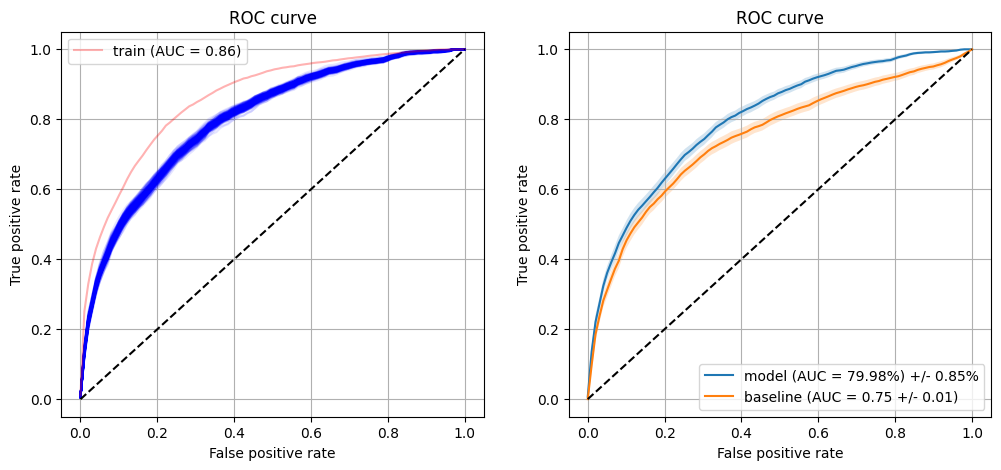

In [11]:
# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
fprs = np.linspace(0, 1, 100)
for tpr_interpolated in tprs_interpolated:
    plt.plot(fprs, tpr_interpolated, "b", alpha=0.1)
plt.plot(fprs, tpr_train, "r", alpha=0.3, label=f"train (AUC = {auc_train:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
tpr_mean, tpr_std = df_results.tpr.to_numpy(), df_results.tpr_std.to_numpy()
auc_mean, auc_std = df_results.auc[0], df_results.auc_std[0]
plt.fill_between(
    fprs, tpr_mean - 2 * tpr_std, tpr_mean + 2 * tpr_std, alpha=0.2
)
plt.plot(fprs, tpr_mean, label=f"model (AUC = {auc_mean:.2%}) +/- {2*auc_std:.2%}")

# add baseline to the plot
df_baseline = pd.read_csv("data/results/baseline_roc.csv")
plt.fill_between(
    df_baseline.fpr,
    df_baseline.tpr - 2 * df_baseline.tpr_std,
    df_baseline.tpr + 2 * df_baseline.tpr_std,
    alpha=0.2,
)
plt.plot(
    df_baseline.fpr.values,
    df_baseline.tpr.values,
    label=f"baseline (AUC = {df_baseline.auc[0]:.2f} +/- {df_baseline.auc_std[0]:.2f})",
)


plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.grid()
plt.show()

In [12]:
Z_score = (auc_mean - df_baseline.auc[0]) / np.sqrt(
    df_baseline.auc_std[0] ** 2 + auc_std ** 2
)
print(f"Z-score = {Z_score:.2f}")

p_value = scipy.stats.norm.sf(abs(Z_score))  # one-sided
print(f"p-value = {p_value:.11%}")

Z-score = 7.00
p-value = 0.00000000013%


## SHAP interpretations

In [13]:
# use SHAP to explain the model
shap.initjs()
nb_max_feature = 10

model = xgb.Booster()
model.load_model(model_file)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[FEATURE_NAME])
test_data = data[FEATURE_NAME]


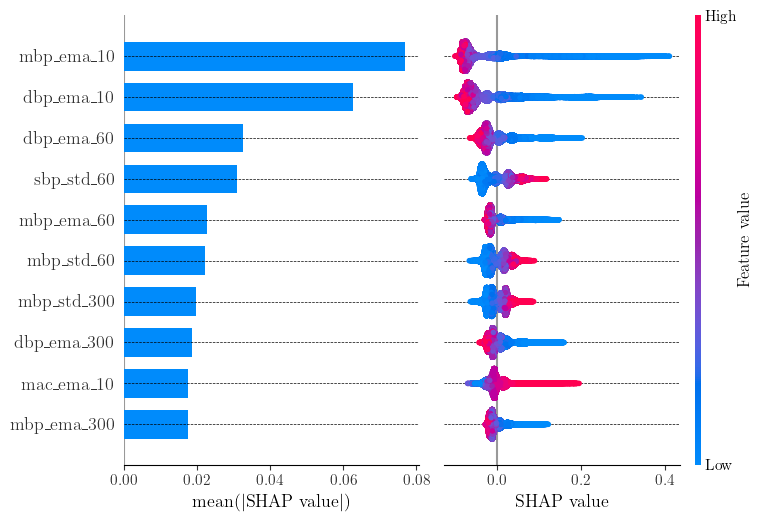

In [14]:
# plot the SHAP value
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean($|$SHAP value$|$)')
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, max_display=nb_max_feature)
#remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
#add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.savefig('./report/figures/shap_xgboost.pdf', bbox_inches='tight', dpi=600)
plt.show()


In [ ]:
# Helper grouping function
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

In [17]:
# Group features
feature_group = {
    'MAP_ema': [name for name in FEATURE_NAME if 'mbp_ema' in name],
    'MAP_std': [name for name in FEATURE_NAME if 'mbp_std' in name],
    'DAP_ema': [name for name in FEATURE_NAME if 'dbp_ema' in name],
    'DAP_std': [name for name in FEATURE_NAME if 'dbp_std' in name],
    'SAP_ema': [name for name in FEATURE_NAME if 'sbp_ema' in name],
    'SAP_std': [name for name in FEATURE_NAME if 'sbp_std' in name],
    'MAC_ema': [name for name in FEATURE_NAME if 'mac_ema' in name],
    'MAC_std': [name for name in FEATURE_NAME if 'mac_std' in name],
    'HR_ema': [name for name in FEATURE_NAME if 'hr_ema' in name],
    'HR_std': [name for name in FEATURE_NAME if 'hr_std' in name],
    'RR_ema': [name for name in FEATURE_NAME if 'rr_ema' in name],
    'RR_std': [name for name in FEATURE_NAME if 'rr_std' in name],
    'SPO2_ema': [name for name in FEATURE_NAME if 'spo2_ema' in name],
    'SPO2_std': [name for name in FEATURE_NAME if 'spo2_std' in name],
    'ETCO2_ema': [name for name in FEATURE_NAME if 'etco2_ema' in name],
    'ETCO2_std': [name for name in FEATURE_NAME if 'etco2_std' in name],
    'PROPO_ema': [name for name in FEATURE_NAME if 'pp_ct_ema' in name],
    'PROPO_std': [name for name in FEATURE_NAME if 'pp_ct_std' in name],
    'AGE': ['age'],
    'BMI': ['bmi'],
    'ASA': ['asa'],
    'PREOP_CR': ['preop_cr'],
    'PREOP_HTN': ['preop_htn'],
}


shap_group = grouped_shap(shap_values, FEATURE_NAME, feature_group)
test_data_group = grouped_shap(test_data, FEATURE_NAME, feature_group)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


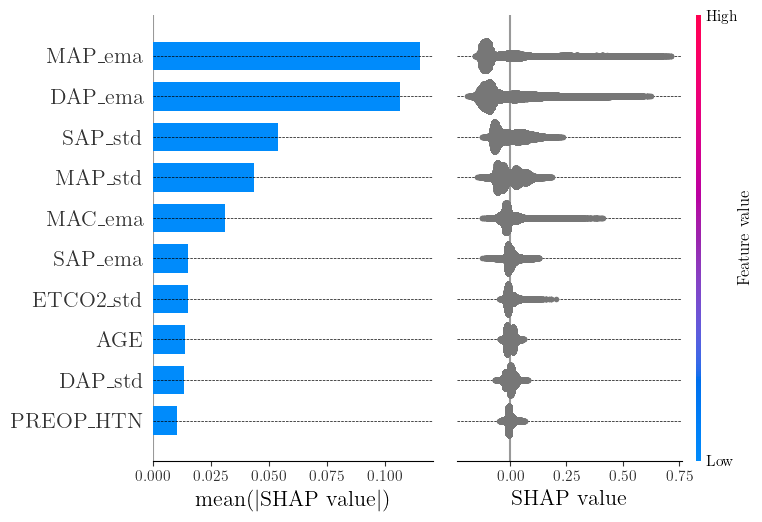

In [18]:
# plot the grouped SHAP value
font_size = 16

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(shap_group, test_data_group, feature_names=shap_group.columns, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean($|$SHAP value$|$)', fontsize=font_size)
ax = plt.gca()
ax.tick_params(axis='y', labelsize=font_size)

plt.subplot(1, 2, 2)
shap.summary_plot(shap_group.values, test_data_group, feature_names=shap_group.columns, max_display=nb_max_feature, show=False)
plt.xlabel('SHAP value', fontsize=font_size)
#remove the y thick label
ax = plt.gca()
ax.set_yticklabels([])
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./report/figures/shap_xgboost_group.pdf', bbox_inches='tight', dpi=600)
plt.show()

## exemple of cases


TypeError: float() argument must be a string or a real number, not 'NAType'

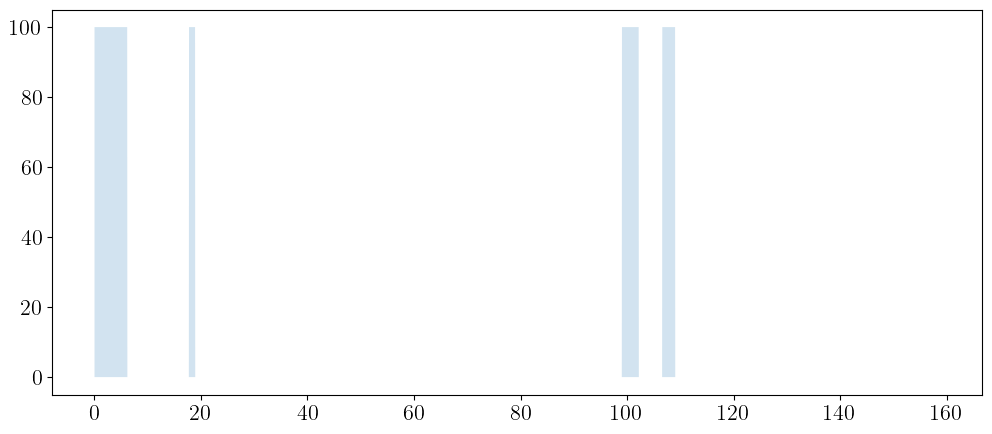

In [14]:
# plot 3 random cases with the corresponding decision function
from scripts.dataLoader import label_caseid

np.random.seed(10)
cases = np.random.choice(test['caseid'].unique(), 3, replace=False)
model = xgb.Booster()
model.load_model(model_file)
for case in cases:
    raw_case = pd.read_parquet(f'data/cases/case-{case:04d}.parquet')
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    # raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # # removing the nan values at the beginning and the ending
    # case_valid_mask = ~raw_case.mbp.isna()
    # raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    raw_case.Time = pd.to_timedelta(raw_case.Time, unit="s")
    raw_case.set_index('Time', inplace=True)
    raw_case = raw_case.resample('2s').first()
    raw_case= label_caseid(raw_case, 2)

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=FEATURE_NAME)
    x_test = segment_data[FEATURE_NAME]
    y_pred = model.predict(xgb.DMatrix(x_test))

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds /60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    # FIXME: raw_case.mbp might be NaN. fillna(0) ?
    plt.plot(raw_case.index.seconds /60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')

    #plot in red point labeled as IOH
    plt.plot(segment_data[segment_data.label>0].time / np.timedelta64(1, 's') /60,y_pred[segment_data.label>0]*100, 'r.', label='model decision function')
    plt.plot(segment_data[segment_data.label==0].time / np.timedelta64(1, 's') /60,y_pred[segment_data.label==0]*100, 'g.', label='model decision function')


    # plt.plot(segment_data.time / np.timedelta64(1, 's') /60,segment_data.time_before_IOH, 'x', label='model decision function')

    plt.xlabel('Time (min)')
    # plt.xlim([100, 120])
    # plt.xlim([235, 245])
    # plt.ylim([0, 100])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()


